## Extract tracer transports and save into files


This notebook extracts the tracer trabnsport through several cross sections along the shelf, across the shelf and vertically, from canyon to shelf. See plot below. Transport is divided in advective and diffusive by the model and stored in files called Flux01Glob.nc (01 is the tracer number for tracer 1).

Advective tracer transport $\Phi_{Tadv}=C\vec{u}\cdot\vec{a}$ 

Diffusive tracer transport $\Phi_{Tdiff}$, includes diffusion due to advection scheme)

| variable  | dims | units | description |
|:---------:|:---------:|:---------:|:---------:|
| UTRAC01   |   (T, Zmd000090, Y, Xp1) | Mol/L.m/s | Zonal Mass-Weighted Transp of Tr1 |
| VTRAC01   |   (T, Zmd000090, Yp1, X) | Mol/L.m/s | Meridional Mass-Weighted Transp of Tr1 |
| WTRAC01   |   (T, Zmd000090, Y, X)   | Mol/L.m/s | Vertical Mass-Weighted Transp of Tr1 |  
| ADVrTr01  |   (T, Zld000090, Y, X)   | Mol/L.m^3/s| Zonal Advective Flux of Tr1 |
| ADVxTr01  |   (T, Zmd000090, Y, Xp1) | Mol/L.m^3/s| Meridional Advective Flux of Tr1 |
| ADVyTr01  |   (T, Zmd000090, Yp1, X) | Mol/L.m^3/s| Vertical Advective Flux of Tr1 |
| DFrETr01  |   (T, Zld000090, Y, X)   | Mol/L.m^3/s| Vertical Diffusive Flux of Tr1 (Explicit part) |
| DFrITr01  |   (T, Zld000090, Y, X)   | Mol/L.m^3/s| Vertical Diffusive Flux of Tr1 (Implicit part) |
| DFxETr01  |   (T, Zmd000090, Y, Xp1) | Mol/L.m^3/s| Zonal Diffusive Flux of Tr1 |
| DFyETr01  |   (T, Zmd000090, Yp1, X) | Mol/L.m^3/s| Meridional Diffusive Flux of Tr1 |


* run##water_CS_transports.nc - cross-shelf and vertical transports

There is one of each files for every run.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import xarray as xr

In [2]:
# Define slices and positions of cross sections 
CS1_x_slice = slice(0, 60)
CS2_x_slice = slice(60, 120)
CS3_x_slice = slice(120, 240)
CS4_x_slice = slice(240, 300)
CS5_x_slice = slice(300, 360)
CS6_x_slice = slice(360,616)  #New slice for extended domain

CSCOAST_x_slice = slice(0, 360)

CS_y_coast = 358
CS1_y_ind = 227

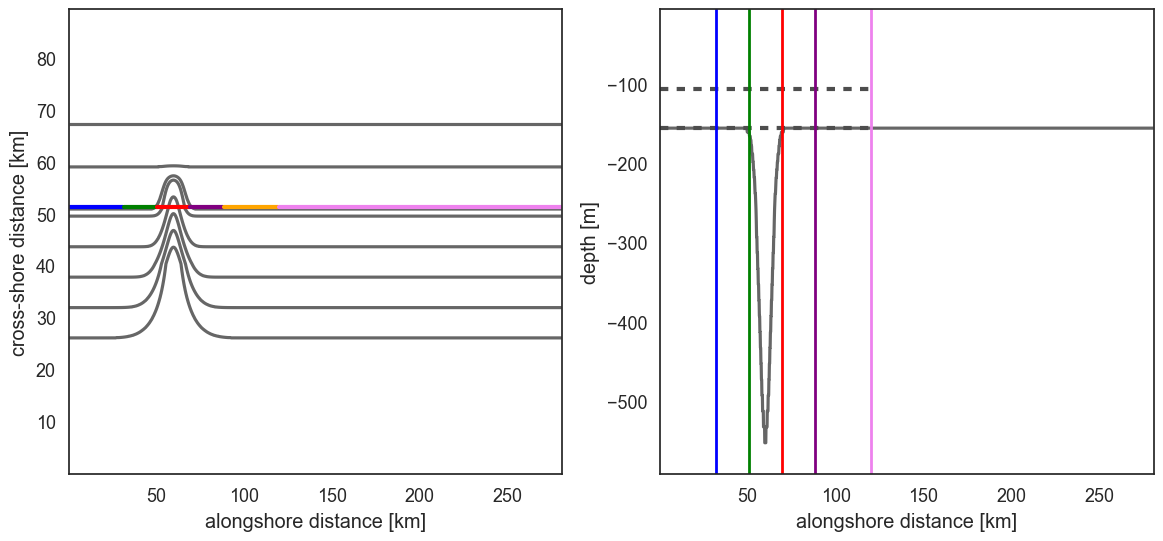

In [3]:
grid_file = '/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
grid = xr.open_dataset(grid_file)

sns.set_style(style='white')
sns.set_context('talk')
fig, ax = plt.subplots(1, 2, figsize=(14,6))

ax[0].contour(grid.X/1000,grid.Y/1000,grid.Depth,[50,100,150,200,400,600,800,1000], colors='0.4')

ax[0].plot(grid.XC[CS1_y_ind,CS1_x_slice]/1000,grid.YC[CS1_y_ind,CS1_x_slice]/1000, 'b-', linewidth=3)
ax[0].plot(grid.XC[CS1_y_ind,CS2_x_slice]/1000,grid.YC[CS1_y_ind,CS2_x_slice]/1000, 'g-', linewidth=3)
ax[0].plot(grid.XC[CS1_y_ind,CS3_x_slice]/1000,grid.YC[CS1_y_ind,CS3_x_slice]/1000, 'r-', linewidth=3)
ax[0].plot(grid.XC[CS1_y_ind,CS4_x_slice]/1000,grid.YC[CS1_y_ind,CS4_x_slice]/1000, '-',color='purple', linewidth=3)
ax[0].plot(grid.XC[CS1_y_ind,CS5_x_slice]/1000,grid.YC[CS1_y_ind,CS5_x_slice]/1000, '-', color='orange', linewidth=3)
ax[0].plot(grid.XC[CS1_y_ind,CS6_x_slice]/1000,grid.YC[CS1_y_ind,CS6_x_slice]/1000, '-', color='violet', linewidth=3)


ax[0].set_xlabel('alongshore distance [km]')
ax[0].set_ylabel('cross-shore distance [km]')

ax[1].contour(grid.XC[227,:]/1000,grid.RC[:60],grid.HFacC[:60,227,:],[0],colors='0.4')
ax[1].plot([grid.X[0]/1000,grid.X[359]/1000],[grid.RC[20],grid.RC[20]], '--', color='0.3', linewidth=3)
ax[1].plot([grid.X[0]/1000,grid.X[359]/1000],[grid.RC[30],grid.RC[30]], '--', color='0.3', linewidth=3)

ax[1].axvline(x=grid.X[60]/1000,color='b', linewidth=2)
ax[1].axvline(x=grid.X[120]/1000,color='g', linewidth=2)
ax[1].axvline(x=grid.X[240]/1000,color='r', linewidth=2)
ax[1].axvline(x=grid.X[300]/1000,color='purple', linewidth=2)
ax[1].axvline(x=grid.X[360]/1000,color='violet', linewidth=2)


ax[1].set_xlabel('alongshore distance [km]')
ax[1].set_ylabel('depth [m]')


In [4]:
def calc_trac_transport_CS(flux_component,hfac, x_slice, y_slice,T,zini=0,zfin=30):
    '''
    INPUT:
    flux_component: xarray, flux component perpendicular to cross section (e.g. unstagger_xarray(flux38.V,'Yp1'))
    x_slice : slice or index of cross-section in alongshore direction
    y_slice : slice or index of cross-section in cross-shore direction
    
    '''
    flux = (flux_component.isel(Zmd000090=slice(zini,zfin),Yp1=y_slice, X=x_slice)).data
    frac = (hfac.isel(Z=slice(zini,zfin),Yp1=y_slice, X=x_slice)).data
    
    return (xr.DataArray(np.sum(np.sum(flux*frac,axis=1),axis=1), coords=T.coords))

 

def unstagger_xarray(qty, index):
    """Interpolate u, v, or w component values to values at grid cell centres.
    
    Named indexing requires that input arrays are XArray DataArrays.

    :arg qty: u, v, or w component values
    :type qty: :py:class:`xarray.DataArray`
    
    :arg index: index name along which to centre
        (generally one of 'gridX', 'gridY', or 'depth')
    :type index: str

    :returns qty: u, v, or w component values at grid cell centres
    :rtype: :py:class:`xarray.DataArray`
    """
    
    qty = (qty + qty.shift(**{index: 1})) / 2
    
    return qty



In [5]:
#set up paths to grid files
grid_Can_file = '/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
grid_NoC_file = '/data/kramosmu/results/TracerExperiments/CNTDIFF/run42/gridGlob.nc'


In [6]:
import os
import sys
lib_path = os.path.abspath('../PythonScripts/Paper1Figures/') # Add absolute path to my python scripts
sys.path.append(lib_path)

import canyon_records 
import nocanyon_records

In [7]:
records = canyon_records.main()
recordsNoC = nocanyon_records.main()

In [8]:
ii=0
for rec in records:
    print(ii,rec.name)
    ii=ii+1

0 CNTDIFF_run38
1 CNTDIFF_run37
2 CNTDIFF_run36
3 CNTDIFF_run45
4 CNTDIFF_run73
5 CNTDIFF_run75
6 CNTDIFF_run67
7 CNTDIFF_run51
8 CNTDIFF_run69
9 CNTDIFF_run71
10 3DVISC_run01
11 3DVISC_run02
12 3DVISC_run04
13 3DVISC_run03
14 3DVISC_run05
15 3DVISC_run06
16 LOWER_BF_run01
17 LOW_BF_run01
18 LOWEST_BF_run01
19 LOWEST_BF_run03
20 LOWEST_BF_run05
21 LOWEST_BF_run07
22 LOWEST_BF_run11


In [9]:
# Select which runs or records to process by index in record (records_sel = [ii for ii in range(23)] selects all runs)
records_sel = [ii for ii in range(23)]
recordsNoC_sel = [ii for ii in range(23)]

### Save tracer transport

In [10]:
grid = xr.open_dataset(grid_Can_file)
gridNoC = xr.open_dataset(grid_NoC_file)


In [18]:
# CNT runs, this should be a function!

ii = 0

for ii in records_sel:
    
    rec = records[ii]
    
    filename=('/data/kramosmu/results/TracerExperiments/%s/%s/FluxTR01Glob.nc' %(rec.exp_code,rec.run_num))
    flux = xr.open_dataset(filename)
    
    advCS1_flux = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), gridNoC.HFacS, CS1_x_slice, 
                                         CS1_y_ind, flux.iter)
    advCS2_flux = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), gridNoC.HFacS, CS2_x_slice, 
                                         CS1_y_ind, flux.iter)
    advCS3_flux = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), gridNoC.HFacS, CS3_x_slice, 
                                         CS1_y_ind, flux.iter)
    advCS3b_flux = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), gridNoC.HFacS,CS3_x_slice,
                                          CS1_y_ind, flux.iter,zini=30,zfin=90)
    advCS4_flux = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), gridNoC.HFacS, CS4_x_slice, 
                                         CS1_y_ind, flux.iter)
    advCS5_flux = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), gridNoC.HFacS, CS5_x_slice, 
                                         CS1_y_ind, flux.iter)
    advCS6_flux = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), gridNoC.HFacS, CS6_x_slice, 
                                         CS1_y_ind, flux.iter)

    
    vel_vert = (unstagger_xarray(flux.ADVrTr01,'Zld000090').isel(Zld000090=30,Y=slice(227,267), X=slice(120,240)))
    advVert_flux = (vel_vert).sum(dim='Y').sum(dim='X')
    
    
    advVert_flux.name = 'Vert_adv_trans_sb'
    advVert_flux.attrs['units'] = '(muM)m3/s'

    advCS1_flux.name = 'CS1_adv_trans'
    advCS1_flux.attrs['units'] = '(muM)m3/s'
    advCS2_flux.name = 'CS2_adv_trans'
    advCS2_flux.attrs['units'] = '(muM)m3/s'
    advCS3_flux.name = 'CS3_adv_trans'
    advCS3_flux.attrs['units'] = '(muM)m3/s'
    advCS3b_flux.name = 'CS3b_adv_trans'
    advCS3b_flux.attrs['units'] = '(muM)m3/s'
    advCS4_flux.name = 'CS4_adv_trans'
    advCS4_flux.attrs['units'] = '(muM)m3/s'
    advCS5_flux.name = 'CS5_adv_trans'
    advCS5_flux.attrs['units'] = '(muM)m3/s'
    advCS6_flux.name = 'CS6_adv_trans'
    advCS6_flux.attrs['units'] = '(muM)m3/s'
   
    
    objectsCS = [advCS1_flux, advCS2_flux,advCS3_flux,advCS3b_flux,advCS4_flux,advCS5_flux,advCS6_flux,advVert_flux]
               
    
    DS_CS = xr.merge(objectsCS, compat='broadcast_equals', join='outer')
    DS_CS_path = (('/data/kramosmu/results/TracerExperiments/%s/%s' %(rec.exp_code,rec.run_num))+
                  'advTracer_CS_transports.nc')
    DS_CS.to_netcdf(path=DS_CS_path, mode='w', engine='scipy')
    
    print(DS_CS_path)
    ii=ii+1
    



/data/kramosmu/results/TracerExperiments/LOWEST_BF/run11advTracer_CS_transports.nc


In [19]:
rec.name

'LOWEST_BF_run11'

In [20]:
# No canyon, advective
ii = 0

for ii in recordsNoC_sel:
    
    rec = recordsNoC[ii]
    
    filename=('/data/kramosmu/results/TracerExperiments/%s/%s/FluxTR01Glob.nc' %(rec.exp_code,rec.run_num))
    flux = xr.open_dataset(filename)
    
    advCS1_flux = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), gridNoC.HFacS, CS1_x_slice,
                                         CS1_y_ind, flux.iter)
    advCS2_flux = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), gridNoC.HFacS, CS2_x_slice, 
                                         CS1_y_ind, flux.iter)
    advCS3_flux = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), gridNoC.HFacS, CS3_x_slice, 
                                         CS1_y_ind, flux.iter)
    advCS3b_flux = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), gridNoC.HFacS,
                                          CS3_x_slice, CS1_y_ind, flux.iter,zini=30,zfin=90)
    advCS4_flux = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), gridNoC.HFacS, CS4_x_slice, 
                                         CS1_y_ind, flux.iter)
    advCS5_flux = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), gridNoC.HFacS, CS5_x_slice, 
                                         CS1_y_ind, flux.iter)
    advCS6_flux = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), gridNoC.HFacS, CS6_x_slice, 
                                         CS1_y_ind, flux.iter)

    
    vel_vert = (unstagger_xarray(flux.ADVrTr01,'Zld000090').isel(Zld000090=30,Y=slice(227,267), X=slice(120,240)))
    advVert_flux = (vel_vert).sum(dim='Y').sum(dim='X')
    
    
    advVert_flux.name = 'Vert_adv_trans_sb'
    advVert_flux.attrs['units'] = 'm3/s'

    advCS1_flux.name = 'CS1_adv_trans'
    advCS1_flux.attrs['units'] = 'm3/s'
    advCS2_flux.name = 'CS2_adv_trans'
    advCS2_flux.attrs['units'] = 'm3/s'
    advCS3_flux.name = 'CS3_adv_trans'
    advCS3_flux.attrs['units'] = 'm3/s'
    advCS3b_flux.name = 'CS3b_adv_trans'
    advCS3b_flux.attrs['units'] = 'm3/s'
    advCS4_flux.name = 'CS4_adv_trans'
    advCS4_flux.attrs['units'] = 'm3/s'
    advCS5_flux.name = 'CS5_adv_trans'
    advCS5_flux.attrs['units'] = 'm3/s'
    advCS6_flux.name = 'CS6_adv_trans'
    advCS6_flux.attrs['units'] = 'm3/s'
   
    
    objectsCS = [advCS1_flux, advCS2_flux,advCS3_flux,advCS3b_flux,advCS4_flux,advCS5_flux,advCS6_flux,advVert_flux]
               
    
    DS_CS = xr.merge(objectsCS, compat='broadcast_equals', join='outer')
    DS_CS_path = (('/data/kramosmu/results/TracerExperiments/%s/%s' %(rec.exp_code,rec.run_num))+
                  'advTracer_CS_transports.nc')
    DS_CS.to_netcdf(path=DS_CS_path, mode='w', engine='scipy')
    
    print(DS_CS_path)
    ii=ii+1

/data/kramosmu/results/TracerExperiments/CNTDIFF/run42advTracer_CS_transports.nc
/data/kramosmu/results/TracerExperiments/CNTDIFF/run41advTracer_CS_transports.nc
/data/kramosmu/results/TracerExperiments/CNTDIFF/run40advTracer_CS_transports.nc
/data/kramosmu/results/TracerExperiments/CNTDIFF/run48advTracer_CS_transports.nc
/data/kramosmu/results/TracerExperiments/CNTDIFF/run74advTracer_CS_transports.nc
/data/kramosmu/results/TracerExperiments/CNTDIFF/run76advTracer_CS_transports.nc
/data/kramosmu/results/TracerExperiments/CNTDIFF/run68advTracer_CS_transports.nc
/data/kramosmu/results/TracerExperiments/CNTDIFF/run53advTracer_CS_transports.nc
/data/kramosmu/results/TracerExperiments/CNTDIFF/run70advTracer_CS_transports.nc
/data/kramosmu/results/TracerExperiments/CNTDIFF/run72advTracer_CS_transports.nc
/data/kramosmu/results/TracerExperiments/CNTDIFF/run50advTracer_CS_transports.nc
/data/kramosmu/results/TracerExperiments/CNTDIFF/run50advTracer_CS_transports.nc
/data/kramosmu/results/Trace

In [12]:
# Canyon, Diffusive 
ii = 0

for ii in records_sel:
    
    rec = records[ii]
    
    filename=('/data/kramosmu/results/TracerExperiments/%s/%s/FluxTR01Glob.nc' %(rec.exp_code,rec.run_num))
    flux = xr.open_dataset(filename)
    
    difCS1_flux = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), gridNoC.HFacS, CS1_x_slice, 
                                         CS1_y_ind,flux.iter)
    difCS2_flux = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), gridNoC.HFacS, CS2_x_slice, 
                                         CS1_y_ind,flux.iter)
    difCS3_flux = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), gridNoC.HFacS, CS3_x_slice, 
                                         CS1_y_ind,flux.iter)
    difCS3b_flux = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), gridNoC.HFacS,
                                          CS3_x_slice, CS1_y_ind,flux.iter,zini=30,zfin=90)
    difCS4_flux = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), gridNoC.HFacS, CS4_x_slice, 
                                         CS1_y_ind,flux.iter)
    difCS5_flux = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), gridNoC.HFacS, CS5_x_slice, 
                                         CS1_y_ind,flux.iter)
    difCS6_flux = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), gridNoC.HFacS, CS6_x_slice, 
                                         CS1_y_ind,flux.iter)

    
    flux_vert_E = (unstagger_xarray(flux.DFrETr01,'Zld000090').isel(Zld000090=30,Y=slice(227,267), X=slice(120,240)))
    flux_vert_I = (unstagger_xarray(flux.DFrITr01,'Zld000090').isel(Zld000090=30,Y=slice(227,267), X=slice(120,240)))
    difVert_flux = (flux_vert_E+flux_vert_I).sum(dim='Y').sum(dim='X')
    
    difVert_flux.name = 'Vert_dif_trans_sb'
    difVert_flux.attrs['units'] = 'm3/s'

    difCS1_flux.name = 'CS1_dif_trans'
    difCS1_flux.attrs['units'] = 'm3/s'
    difCS2_flux.name = 'CS2_dif_trans'
    difCS2_flux.attrs['units'] = 'm3/s'
    difCS3_flux.name = 'CS3_dif_trans'
    difCS3_flux.attrs['units'] = 'm3/s'
    difCS3b_flux.name = 'CS3b_dif_trans'
    difCS3b_flux.attrs['units'] = 'm3/s'
    difCS4_flux.name = 'CS4_dif_trans'
    difCS4_flux.attrs['units'] = 'm3/s'
    difCS5_flux.name = 'CS5_dif_trans'
    difCS5_flux.attrs['units'] = 'm3/s'
    difCS6_flux.name = 'CS6_dif_trans'
    difCS6_flux.attrs['units'] = 'm3/s'
   
    
    objectsCS = [difCS1_flux, difCS2_flux,difCS3_flux,difCS3b_flux,difCS4_flux,difCS5_flux,difCS6_flux,difVert_flux]
               
    
    DS_CS = xr.merge(objectsCS, compat='broadcast_equals', join='outer')
    DS_CS_path = (('/data/kramosmu/results/TracerExperiments/%s/%s' %(rec.exp_code,rec.run_num))+
                  'difTracer_CS_transports.nc')
    DS_CS.to_netcdf(path=DS_CS_path, mode='w', engine='scipy')
    
    print(DS_CS_path)
    ii=ii+1
    



/data/kramosmu/results/TracerExperiments/CNTDIFF/run38difTracer_CS_transports.nc
/data/kramosmu/results/TracerExperiments/CNTDIFF/run37difTracer_CS_transports.nc
/data/kramosmu/results/TracerExperiments/CNTDIFF/run36difTracer_CS_transports.nc
/data/kramosmu/results/TracerExperiments/CNTDIFF/run45difTracer_CS_transports.nc
/data/kramosmu/results/TracerExperiments/CNTDIFF/run73difTracer_CS_transports.nc
/data/kramosmu/results/TracerExperiments/CNTDIFF/run75difTracer_CS_transports.nc
/data/kramosmu/results/TracerExperiments/CNTDIFF/run67difTracer_CS_transports.nc
/data/kramosmu/results/TracerExperiments/CNTDIFF/run51difTracer_CS_transports.nc
/data/kramosmu/results/TracerExperiments/CNTDIFF/run69difTracer_CS_transports.nc
/data/kramosmu/results/TracerExperiments/CNTDIFF/run71difTracer_CS_transports.nc
/data/kramosmu/results/TracerExperiments/3DVISC/run01difTracer_CS_transports.nc
/data/kramosmu/results/TracerExperiments/3DVISC/run02difTracer_CS_transports.nc
/data/kramosmu/results/TracerE

In [13]:
# Canyon, Diffusive 
ii = 0

for ii in recordsNoC_sel:
    
    rec = recordsNoC[ii]
    
    filename=('/data/kramosmu/results/TracerExperiments/%s/%s/FluxTR01Glob.nc' %(rec.exp_code,rec.run_num))
    flux = xr.open_dataset(filename)
    
    difCS1_flux = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), gridNoC.HFacS, CS1_x_slice, 
                                         CS1_y_ind,flux.iter)
    difCS2_flux = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), gridNoC.HFacS, CS2_x_slice, 
                                         CS1_y_ind,flux.iter)
    difCS3_flux = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), gridNoC.HFacS, CS3_x_slice, 
                                         CS1_y_ind,flux.iter)
    difCS3b_flux = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), gridNoC.HFacS,
                                          CS3_x_slice, CS1_y_ind,flux.iter,zini=30,zfin=90)
    difCS4_flux = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), gridNoC.HFacS, CS4_x_slice, 
                                         CS1_y_ind,flux.iter)
    difCS5_flux = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), gridNoC.HFacS, CS5_x_slice, 
                                         CS1_y_ind,flux.iter)
    difCS6_flux = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), gridNoC.HFacS, CS6_x_slice, 
                                         CS1_y_ind,flux.iter)

    
    flux_vert_E = (unstagger_xarray(flux.DFrETr01,'Zld000090').isel(Zld000090=30,Y=slice(227,267), X=slice(120,240)))
    flux_vert_I = (unstagger_xarray(flux.DFrITr01,'Zld000090').isel(Zld000090=30,Y=slice(227,267), X=slice(120,240)))
    difVert_flux = (flux_vert_E+flux_vert_I).sum(dim='Y').sum(dim='X')
    
    difVert_flux.name = 'Vert_dif_trans_sb'
    difVert_flux.attrs['units'] = 'm3/s'

    difCS1_flux.name = 'CS1_dif_trans'
    difCS1_flux.attrs['units'] = 'm3/s'
    difCS2_flux.name = 'CS2_dif_trans'
    difCS2_flux.attrs['units'] = 'm3/s'
    difCS3_flux.name = 'CS3_dif_trans'
    difCS3_flux.attrs['units'] = 'm3/s'
    difCS3b_flux.name = 'CS3b_dif_trans'
    difCS3b_flux.attrs['units'] = 'm3/s'
    difCS4_flux.name = 'CS4_dif_trans'
    difCS4_flux.attrs['units'] = 'm3/s'
    difCS5_flux.name = 'CS5_dif_trans'
    difCS5_flux.attrs['units'] = 'm3/s'
    difCS6_flux.name = 'CS6_dif_trans'
    difCS6_flux.attrs['units'] = 'm3/s'
   
    
    objectsCS = [difCS1_flux, difCS2_flux,difCS3_flux,difCS3b_flux,difCS4_flux,difCS5_flux,difCS6_flux,difVert_flux]
               
    
    DS_CS = xr.merge(objectsCS, compat='broadcast_equals', join='outer')
    DS_CS_path = (('/data/kramosmu/results/TracerExperiments/%s/%s' %(rec.exp_code,rec.run_num))+
                  'difTracer_CS_transports.nc')
    DS_CS.to_netcdf(path=DS_CS_path, mode='w', engine='scipy')
    
    print(DS_CS_path)
    ii=ii+1

/data/kramosmu/results/TracerExperiments/CNTDIFF/run42difTracer_CS_transports.nc
/data/kramosmu/results/TracerExperiments/CNTDIFF/run41difTracer_CS_transports.nc
/data/kramosmu/results/TracerExperiments/CNTDIFF/run40difTracer_CS_transports.nc
/data/kramosmu/results/TracerExperiments/CNTDIFF/run48difTracer_CS_transports.nc
/data/kramosmu/results/TracerExperiments/CNTDIFF/run74difTracer_CS_transports.nc
/data/kramosmu/results/TracerExperiments/CNTDIFF/run76difTracer_CS_transports.nc
/data/kramosmu/results/TracerExperiments/CNTDIFF/run68difTracer_CS_transports.nc
/data/kramosmu/results/TracerExperiments/CNTDIFF/run53difTracer_CS_transports.nc
/data/kramosmu/results/TracerExperiments/CNTDIFF/run70difTracer_CS_transports.nc
/data/kramosmu/results/TracerExperiments/CNTDIFF/run72difTracer_CS_transports.nc
/data/kramosmu/results/TracerExperiments/CNTDIFF/run50difTracer_CS_transports.nc
/data/kramosmu/results/TracerExperiments/CNTDIFF/run50difTracer_CS_transports.nc
/data/kramosmu/results/Trace

In [ ]:
flux.T